In [2]:
import pandas as pd

In [3]:
data_source = pd.read_csv('disbursment.csv')

In [4]:
data_source.head()

,age,live_province,live_city,live_area_big,live_area_small,sex,marital,bank,salary,amount,penalty_day
0,28,DKI Jakarta,Jakarta Selatan,Pesanggrahan,Bintaro,0,3,MANDIRI,5555555,507350.0,61
1,19,Jawa Tengah,Semarang,Semarang Utara,Purwosari,0,4,MANDIRI,644552585855,514700.0,23
2,38,DKI Jakarta,Jakarta Utara,Pademangan,Ancol,0,3,MANDIRI,585858,507350.0,30
3,18,DKI Jakarta,Jakarta Timur,Pasar Rebo,Baru,0,3,MANDIRI,979764,514700.0,46
4,37,DKI Jakarta,Jakarta Utara,Cilincing,Kali Baru,1,4,MANDIRI,865656,1029400.0,0


## Labelling

In [5]:
data = data_source.copy()

In [6]:
data['Label'] = [0 if x>14 else 1 for x in data_source['penalty_day']]

In [7]:
data = data.drop(columns={'penalty_day'})

In [8]:
data.head()

,age,live_province,live_city,live_area_big,live_area_small,sex,marital,bank,salary,amount,Label
0,28,DKI Jakarta,Jakarta Selatan,Pesanggrahan,Bintaro,0,3,MANDIRI,5555555,507350.0,0
1,19,Jawa Tengah,Semarang,Semarang Utara,Purwosari,0,4,MANDIRI,644552585855,514700.0,0
2,38,DKI Jakarta,Jakarta Utara,Pademangan,Ancol,0,3,MANDIRI,585858,507350.0,0
3,18,DKI Jakarta,Jakarta Timur,Pasar Rebo,Baru,0,3,MANDIRI,979764,514700.0,0
4,37,DKI Jakarta,Jakarta Utara,Cilincing,Kali Baru,1,4,MANDIRI,865656,1029400.0,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16695 entries, 0 to 16694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16695 non-null  int64  
 1   live_province    16695 non-null  object 
 2   live_city        16688 non-null  object 
 3   live_area_big    16686 non-null  object 
 4   live_area_small  16680 non-null  object 
 5   sex              16695 non-null  int64  
 6   marital          16695 non-null  int64  
 7   bank             16695 non-null  object 
 8   salary           16695 non-null  int64  
 9   amount           16695 non-null  float64
 10  Label            16695 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 1.4+ MB


## PyCaret

In [10]:
from pycaret.classification import *

In [11]:
data_model = data.sample(frac=0.95, random_state=786).reset_index(drop=True)
data_unseen = data.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data_model.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (15860, 11)
Unseen Data For Predictions: (0, 11)


In [12]:
clf101 = setup(data = data_model, target = 'Label', session_id=123, log_data = True) 

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(15860, 11)"
4,Missing Values,True
5,Numeric Features,3
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [12]:
#compare_models(blacklist = ['ridge', 'qda', 'lda', 'xgboost', 'nb', 'et', 'knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.7311,0.6177,0.9772,0.7357,0.8394,0.1045,0.1696,13.2383
1,Gradient Boosting Classifier,0.7292,0.6163,0.9817,0.7327,0.8391,0.0868,0.1537,39.6714
2,Light Gradient Boosting Machine,0.7256,0.6145,0.9557,0.7392,0.8336,0.1191,0.1629,1.2216
3,Ada Boost Classifier,0.7232,0.5986,0.9746,0.7306,0.8351,0.0724,0.1232,14.9067
4,Logistic Regression,0.7193,0.5668,1.0000,0.7193,0.8367,0.0000,0.0000,3.1686
5,SVM - Linear Kernel,0.7184,0.0000,0.9986,0.7191,0.8361,-0.0015,-0.0103,2.7069
6,Random Forest Classifier,0.6675,0.6121,0.8605,0.7273,0.7883,0.0391,0.0423,1.2428
7,Decision Tree Classifier,0.6460,0.5253,0.7980,0.7334,0.7643,0.0584,0.0592,3.1100


In [13]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7399,0.5951,0.9875,0.7388,0.8452,0.1265,0.2173
1,0.7369,0.6155,0.9825,0.7385,0.8432,0.1196,0.1976
2,0.7378,0.6583,0.9825,0.7392,0.8436,0.1238,0.2027
3,0.7324,0.6399,0.9787,0.7363,0.8404,0.1057,0.1731
4,0.7387,0.6517,0.9812,0.7403,0.8439,0.1302,0.2080
5,0.7243,0.5736,0.9787,0.7299,0.8362,0.0714,0.1264
6,0.7153,0.5956,0.9637,0.7282,0.8296,0.0585,0.0915
7,0.7261,0.6282,0.9712,0.7339,0.8360,0.0943,0.1474
8,0.7333,0.5960,0.9737,0.7386,0.8400,0.1227,0.1864
9,0.7261,0.6237,0.9724,0.7335,0.8362,0.0919,0.1459


In [14]:
tuned_catboost = tune_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7309,0.5915,0.9875,0.7319,0.8407,0.0841,0.1620
1,0.7342,0.6023,0.9887,0.7342,0.8427,0.0949,0.1801
2,0.7369,0.6625,0.9875,0.7367,0.8439,0.1102,0.1969
3,0.7306,0.6459,0.9850,0.7328,0.8404,0.0851,0.1576
4,0.7351,0.6430,0.9912,0.7340,0.8435,0.0944,0.1865
5,0.7243,0.5713,0.9850,0.7278,0.8371,0.0589,0.1182
6,0.7171,0.5981,0.9687,0.7279,0.8312,0.0571,0.0937
7,0.7261,0.6194,0.9737,0.7330,0.8364,0.0895,0.1444
8,0.7369,0.5955,0.9825,0.7382,0.8430,0.1232,0.2021
9,0.7297,0.6269,0.9862,0.7314,0.8399,0.0823,0.1564


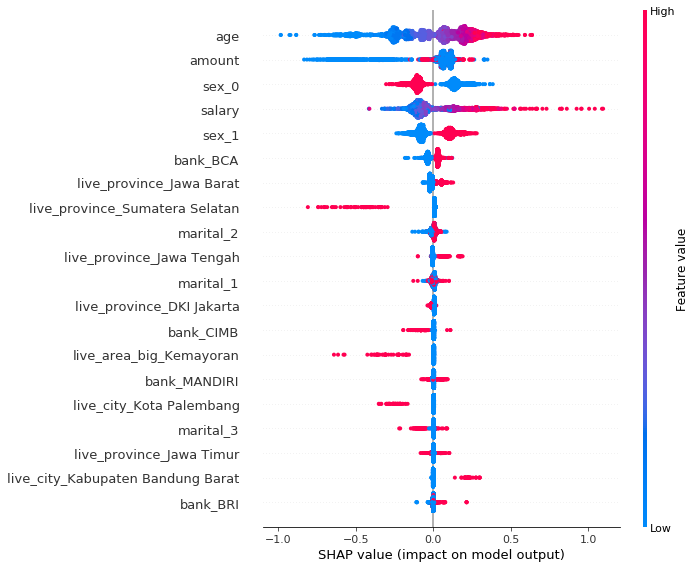

In [15]:
interpret_model(catboost)

In [17]:
interpret_model(catboost, plot = 'reason', observation = 10)

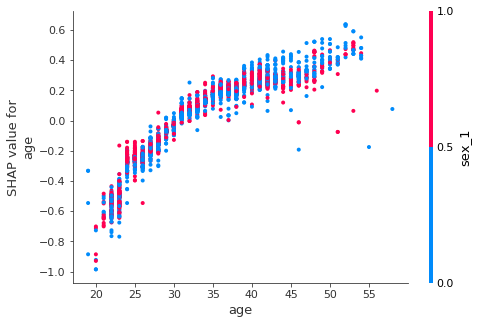

In [18]:
interpret_model(catboost, plot = 'correlation')

In [20]:
predict_model(catboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7256,0.6158,0.9684,0.7345,0.8354,0.0955,0.1456


In [21]:
final_catboost = finalize_model(catboost)

In [25]:
final_catboost;

In [29]:
predict_model(final_catboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7508,0.7531,0.9833,0.7488,0.8502,0.1831,0.2715


In [28]:
save_model(final_catboost,'catboost_cm_creditable')

Transformation Pipeline and Model Succesfully Saved


# app.py

In [33]:
from pycaret.classification import *
import streamlit as st
import pandas as pd
import numpy as np

model = load_model('catboost_cm_creditable')

def predict(model, input_df):
    predictions_df = predict_model(estimator=model, data=input_df)
    predictions = predictions_df['Label'][0]
    return predictions

def run():

    from PIL import Image
    image = Image.open('logo.png')
    image_hospital = Image.open('hospital.jpg')

    st.image(image,use_column_width=False)

    add_selectbox = st.sidebar.selectbox(
    "How would you like to predict?",
    ("Online", "Batch"))

    st.sidebar.info('This app is created by Bhaskoro Muthohar')
    st.sidebar.success('https://www.pycaret.org')
    
    st.sidebar.image(image_hospital)

    st.title("Credit Score Prediction App")

    if add_selectbox == 'Online':

        age = st.number_input('Age', min_value=1, max_value=100, value=25)
        live_province = st.text_input('Provinsi tinggal', 'DKI Jakarta')
        live_city = st.text_input('Kota tinggal', 'Jakarta Selatan')
        live_area_big = st.text_input('Kelurahan', 'Pesanggrahan')
        live_area_small = st.text_input('Kecamatan', 'Bintaro')
        sex = st.selectbox('Jenis Kelamin', ['0', '1'])
        marital = st.selectbox('Status Perkawinan', ['0', '1', '2', '3'])
        bank = st.text_input('Bank', 'BCA')
        salary = st.number_input('Penghasilan', min_value=100000, max_value=100000000, value=100000)
        amount = st.number_input('Jumlah Pinjaman', min_value=100000, max_value=100000000, value=100000)
        output=""

        input_dict = {'age' : age, 'live_province' : live_province, 'live_city' : live_city, 'live_area_big' : live_area_big, 
                      'live_area_small' : live_area_small, 'sex' : sex, 'marital' : marital, 'bank' : bank, 'salary' : salary, 'amount': amount}
        
        input_df = pd.DataFrame([input_dict])

        if st.button("Predict"):
            output = predict(model=model, input_df=input_df)
            output = '$' + str(output)

        st.success('The output is {}'.format(output))

    if add_selectbox == 'Batch':

        file_upload = st.file_uploader("Upload csv file for predictions", type=["csv"])

        if file_upload is not None:
            data = pd.read_csv(file_upload)
            predictions = predict_model(estimator=model,data=data)
            st.write(predictions)

if __name__ == '__main__':
    run()

Transformation Pipeline and Model Sucessfully Loaded
image/png
image/jpeg


SyntaxError: invalid syntax (<ipython-input-34-718866ff34b9>, line 1)